In this noteboook, we
- clean the Penmanshiel data,
- make plausibility checks of wind speed and angle features,
- and compute ambient wind conditions.

### Preparation

In [14]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import energy_data_lab as edl

In [2]:
import os
base_dir = os.path.dirname(os.path.dirname(os.getcwd()))
processed_data_path = os.path.join(base_dir, 'data', 'processed')

### Load Data

In [3]:
df = pd.read_csv(
        os.path.join(processed_data_path, "Penmanshiel_SCADA_2022.csv"), index_col=0
    )
df.head()

,Wind speed (m/s),Wind direction (°),Nacelle position (°),Vane position 1+2 (°),Power (kW),Potential power learned PC (kW),turbine,timestamp
timestamp_turbine,,,,,,,,
2022-01-01 00:00:00 T01,10.454255,190.406676,192.949493,-1.468041,1652.268530,1526.705644,T01,2022-01-01 00:00:00
2022-01-01 00:10:00 T01,10.547255,190.905744,192.949493,-1.822471,1634.746948,1551.595460,T01,2022-01-01 00:10:00
2022-01-01 00:20:00 T01,10.036760,186.150688,187.677100,-0.937917,1400.744108,1414.499698,T01,2022-01-01 00:20:00
2022-01-01 00:30:00 T01,10.350545,187.775551,185.413976,1.191623,1583.718368,1498.832558,T01,2022-01-01 00:30:00
2022-01-01 00:40:00 T01,10.569531,184.599325,189.511337,-3.556806,1572.652897,1557.532673,T01,2022-01-01 00:40:00


### Clean Wind Data

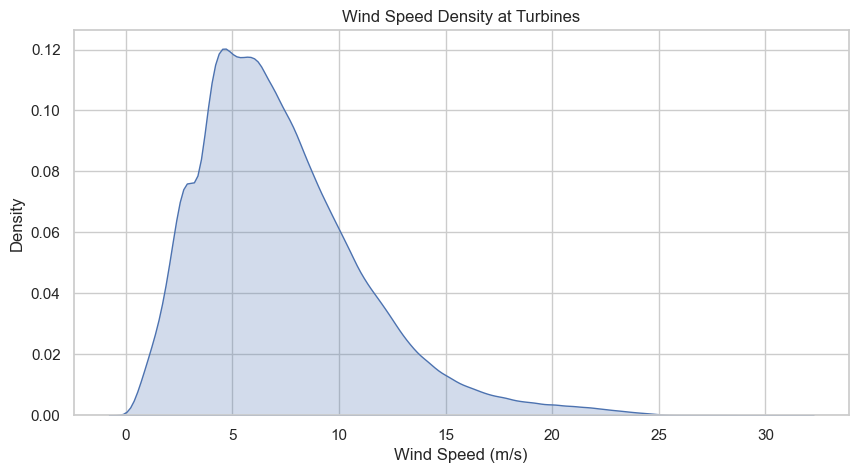

In [4]:
# plot wind speed density
sns.set_theme(style="whitegrid")
fig, axs = plt.subplots(1,1,figsize=(10, 5))
sns.kdeplot(df['Wind speed (m/s)'], fill=True, ax=axs)
axs.set_title('Wind Speed Density at Turbines')
axs.set_xlabel('Wind Speed (m/s)')
plt.show()

Looks reasonable, no need to clean data.

### Clean Power Data (Negative Power & Power Curve)

In [5]:
# treat negative active power values as zero values
print(f'{len(df.loc[df["Power (kW)"] < 0]) / len(df): .4f}% of active power values were < 0.')
df.loc[df["Power (kW)"] < 0, "Power (kW)"] = 0

 0.1662% of active power values were < 0.


Outlier Quantiles:
0.05      0.000000
0.10      0.000000
0.50     24.300406
0.90    106.695604
0.95    155.464085
dtype: float64


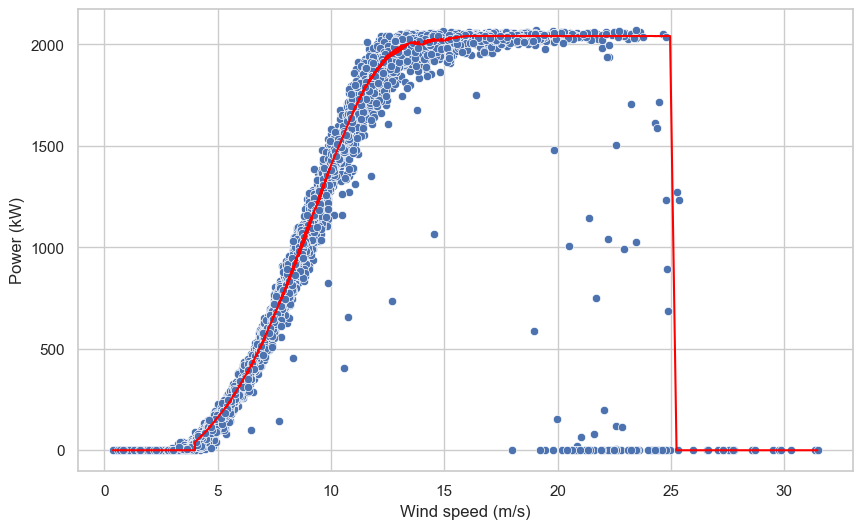

In [6]:
# power curve
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(data=df[:5000], x='Wind speed (m/s)', y='Power (kW)', ax=ax)
# draw theoretical PC as lineplot
sns.lineplot(data=df[:5000], x='Wind speed (m/s)', y='Potential power learned PC (kW)', ax=ax, color='red')
# print several quantiles of real power minus theoretical PC
print("Outlier Quantiles:")
print(abs(df['Power (kW)']- df['Potential power learned PC (kW)']).quantile([0.05, 0.1, 0.5, 0.9, 0.95]))
#sns.kdeplot(abs(df.iloc[:5000, 6] - df.iloc[:5000, 8]), ax=ax)
plt.show()

We replace too large deviations from the power curve with the theoretical power curve value.
Looking at the outlier quantiles, we decide that "too large" refers to a deviation of greater or equal to 100kW.

We'll swap 11.0444% of the data.
Cleaned Data:


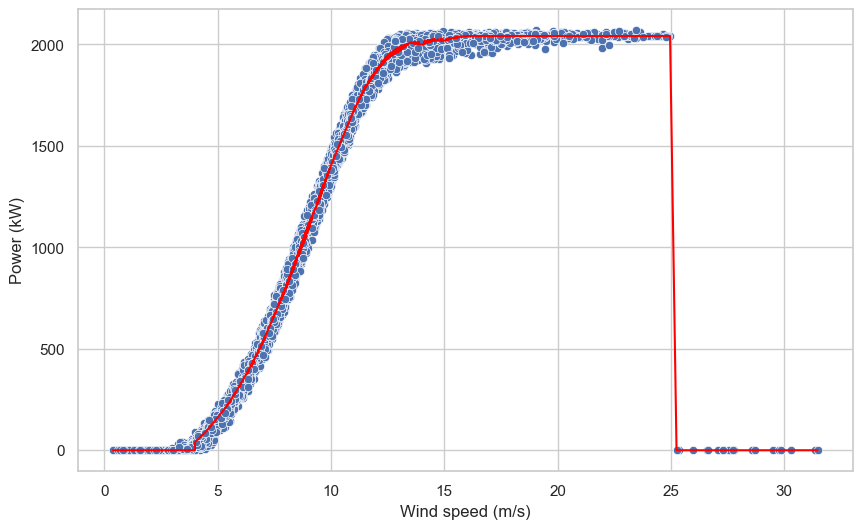

In [7]:
# replace all values where true power minus theoretical PC is greater than 100
swap_idx = df.loc[abs(df['Power (kW)'] - df['Potential power learned PC (kW)']) > 100].index
print(f"We'll swap {100*len(swap_idx)/len(df):.4f}% of the data.")
df.loc[swap_idx, "Power (kW)"] = df.loc[swap_idx, 'Potential power learned PC (kW)']
# power curve
print("Cleaned Data:")
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(data=df[:5000], x='Wind speed (m/s)', y='Power (kW)', ax=ax)
# draw theoretical PC as lineplot
sns.lineplot(data=df[:5000], x='Wind speed (m/s)', y='Potential power learned PC (kW)', ax=ax, color='red')
plt.show()

### Create DataFrames With Turbines as Columns

In [8]:
# create DataFrames for each variable with turbines as columns
df_power = df.pivot(index='timestamp', columns='turbine', values='Power (kW)')
df_wspd = df.pivot(index='timestamp', columns='turbine', values='Wind speed (m/s)')
df_wdir = df.pivot(index='timestamp', columns='turbine', values='Wind direction (°)')
df_ndir = df.pivot(index='timestamp', columns='turbine', values='Nacelle position (°)')
df_vdir = df.pivot(index='timestamp', columns='turbine', values='Vane position 1+2 (°)')
df_power.head()

turbine,T01,T02,T04,T05,T06,T07,T08,T09,T10,T11,T12,T13,T14,T15
timestamp,,,,,,,,,,,,,,
2022-01-01 00:00:00,1526.705644,1639.085986,1608.382902,1557.281079,1591.170052,1245.707821,1227.890191,706.736159,823.451956,1491.428471,1633.688426,1393.650985,1690.007639,1478.170398
2022-01-01 00:10:00,1634.746948,1530.285002,1670.732361,1419.622316,1371.290543,940.130993,1376.357741,611.150427,715.576781,1313.111591,1948.493123,1507.278308,1571.218001,1319.695907
2022-01-01 00:20:00,1400.744108,1264.936729,1387.687138,1145.813273,1148.942981,716.920236,635.155156,670.556531,631.809209,924.054688,1078.036361,998.850976,987.529871,1157.681897
2022-01-01 00:30:00,1583.718368,1554.384334,1782.313066,1443.902526,1478.162317,1111.400348,951.750777,854.737996,830.635793,1221.627411,1200.266056,1129.202232,1631.790456,1444.214387
2022-01-01 00:40:00,1572.652897,1482.852804,1699.350028,1541.057749,1394.629812,989.392627,972.803982,840.334021,836.063975,1315.883140,1397.984314,1059.352384,1586.373043,1523.082642


### Handling Missing Values

 8.9726% missing power values.
 10.7915% missing wind speed values.
 8.9726% missing wind direction values.
 8.9726% missing nacelle direction values.
 9.3246% missing vane direction values.
Number of unique indices to exclude when looking at all dfs: 5729
Number of indices to exclude when looking at power only: 4716


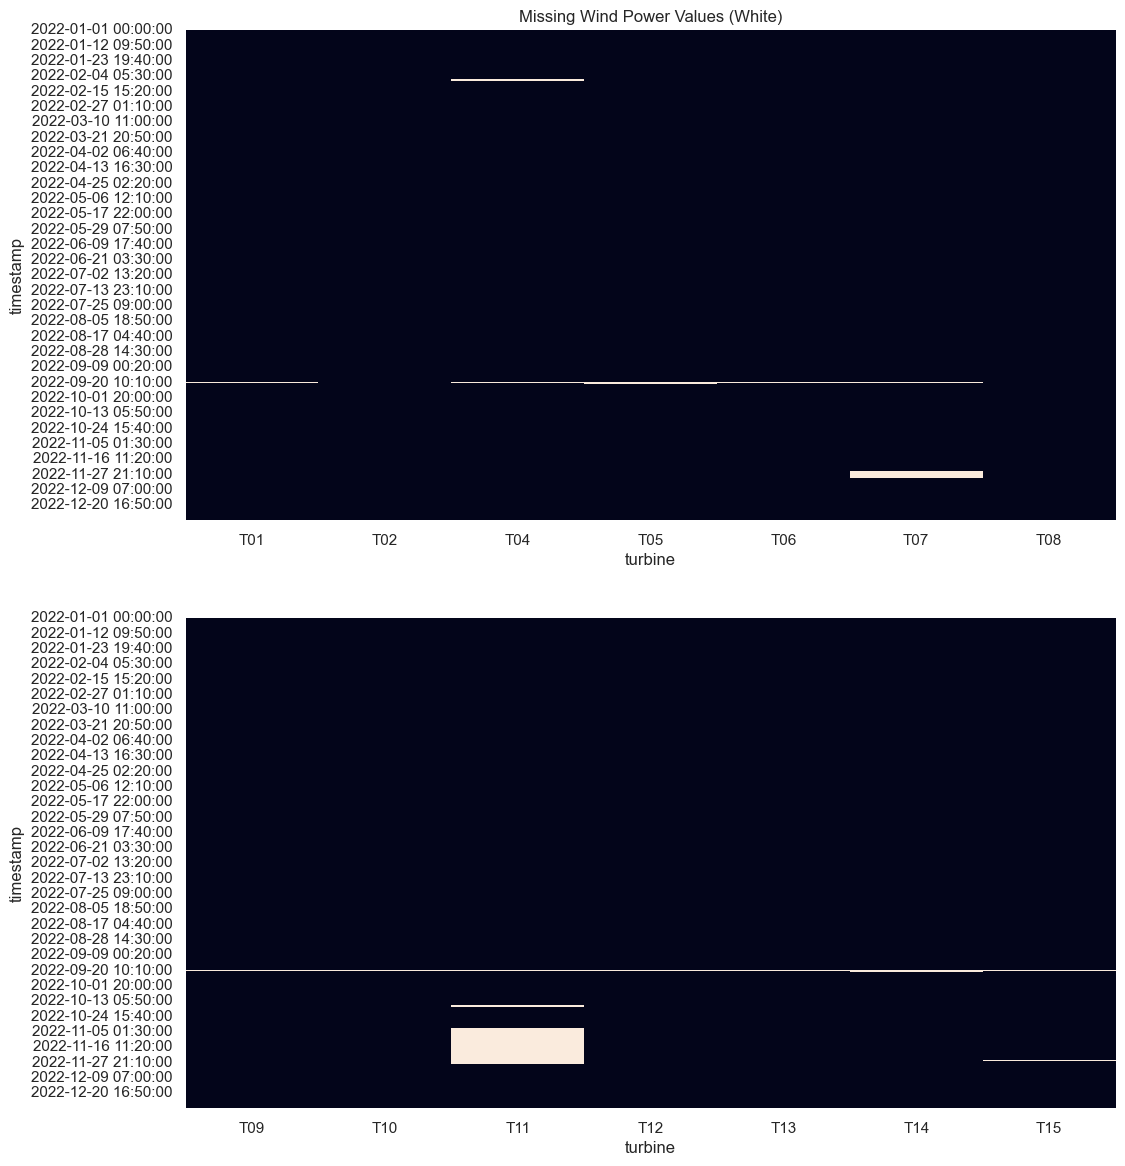

In [9]:
leaveout_power_indices = np.where(df_power.isna().any(axis=1) == True)[0]
leaveout_wspd_indices = np.where(df_wspd.isna().any(axis=1) == True)[0]
leaveout_wdir_indices = np.where(df_wdir.isna().any(axis=1) == True)[0]
leaveout_ndir_indices = np.where(df_ndir.isna().any(axis=1) == True)[0]
leaveout_vdir_indices = np.where(df_vdir.isna().any(axis=1) == True)[0]
print(f"{100*len(leaveout_power_indices)/len(df_power): .4f}% missing power values.")
print(f"{100*len(leaveout_wspd_indices)/len(df_power): .4f}% missing wind speed values.")
print(f"{100*len(leaveout_wdir_indices)/len(df_power): .4f}% missing wind direction values.")
print(f"{100*len(leaveout_ndir_indices)/len(df_power): .4f}% missing nacelle direction values.")
print(f"{100*len(leaveout_vdir_indices)/len(df_power): .4f}% missing vane direction values.")
leaveout_indices_all = np.unique(np.concatenate((leaveout_power_indices,
                                                    leaveout_wspd_indices,
                                                    #leaveout_wspd_clean_indices,
                                                    leaveout_wdir_indices,
                                                    leaveout_ndir_indices,
                                                    leaveout_vdir_indices
                                                 ), axis=None))
print(f'Number of unique indices to exclude when looking at all dfs: {len(leaveout_indices_all)}')
print(f'Number of indices to exclude when looking at power only: {len(leaveout_power_indices)}')
fig, axs = plt.subplots(2, 1, figsize=(12, 14))
sns.heatmap(df_power.iloc[:,:round(df_power.shape[1]/2)].isnull(), cbar=False, ax=axs[0])
sns.heatmap(df_power.iloc[:,round(df_power.shape[1]/2):].isnull(), cbar=False, ax=axs[1])
axs[0].set_title('Missing Wind Power Values (White)')
plt.show()

The missing values seem systematic instead of random (which would have been easy to fill with interpolation, for example). Therefore, we drop all missing values. In particular, we drop all rows where there's a missing value in at least one of the variables.

In [10]:
df_power.drop(df_power.index[leaveout_indices_all], inplace=True)
df_wspd.drop(df_wspd.index[leaveout_indices_all], inplace=True)
df_wdir.drop(df_wdir.index[leaveout_indices_all], inplace=True)
df_ndir.drop(df_ndir.index[leaveout_indices_all], inplace=True)
df_vdir.drop(df_vdir.index[leaveout_indices_all], inplace=True)

### Angle Measurements

Nacelle direction is typically the angle between rotor axis and the truth north ($\phi_{np}$). The wind direction is measured using the vane. Wind direction ($\phi_{wd}$) in our data is given as the absolute wind direction (i.e., not relative to the turbine, but relative to the true north). The contained angle between the absolute wind direction and the nacelle ($\phi_{ye}$) can be computed as difference of wind direction and nacelle position. This should be the same angle as the vane position, i.e.

$$\phi_{ye} = \phi_{wd} - \phi_{np}$$

![image info](../../figures/angles.png)

In [11]:
df['Computed vane position 1+2 (°)'] = df['Wind direction (°)'] - df['Nacelle position (°)']

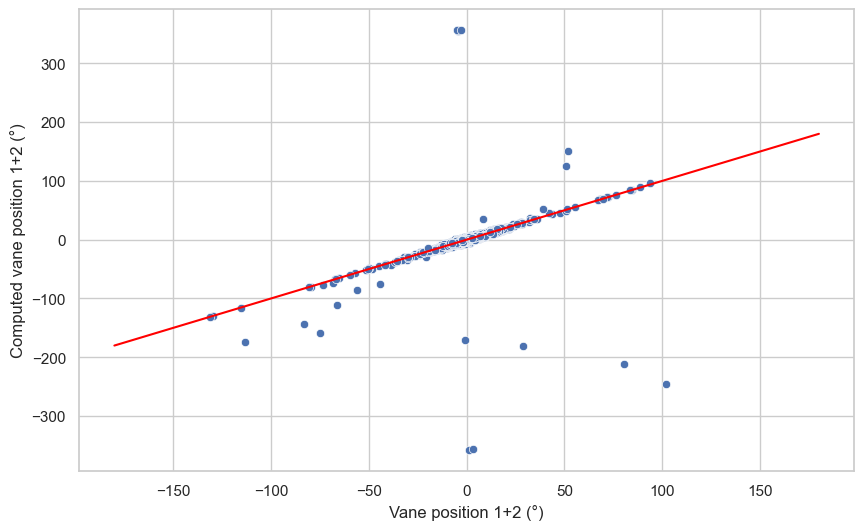

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(data=df[:5000], x='Vane position 1+2 (°)', y='Computed vane position 1+2 (°)', ax=ax)
# draw vertical line f(x) = x
sns.lineplot(x=[-180, 180], y=[-180, 180], ax=ax, color='red')
plt.show()

The plot shows that our variable interpretation was correct. There are only few deviations, which one might consider cleaning. We will only proceed with wind speed and power values, so we refrain from doing so for now.

In [13]:
if not os.path.exists(os.path.join(processed_data_path, "Cleaned_WP.csv")):
    df_power.to_csv(os.path.join(processed_data_path, "Cleaned_WP.csv"))
if not os.path.exists(os.path.join(processed_data_path, "Cleaned_WS.csv")):
    df_wspd.to_csv(os.path.join(processed_data_path, "Cleaned_WS.csv"))

#### Register This Notebook and Cleaned Data to EDL

In [ ]:
edl.register_code(
    name="Clean Processed Data",
    description="Replace false power measurements, drop missing data. Save cleaned data to two CSVs (wind power and speed) with turbines as columns.",
    file_type="IPYNB",
    source_url="https://gitlab.lrz.de/EMT/projects/edl-projects/registry-mvp/-/blob/main/usecases/wpf/src/data/02_cleaning.ipynb",
    download_url="https://gitlab.lrz.de/EMT/projects/edl-projects/registry-mvp/-/raw/main/usecases/wpf/src/data/01_preprocess_raw.py?inline=false",
    pipeline_name="Wind Power Forecasting",
    parent_name="Penmanshiel SCADA 2022 WT01-10",
)